### Project Objective
The objective of this project is to use machine learning to predict which cosmetic products are most likely to be reformulated. This analysis is based on data from the California Safe Cosmetics Program (CSCP) and aims to provide actionable insights for cosmetic chemists and manufacturers to support proactive, safety-driven product development.

In [ ]:
## This is the first notebook that summarizes the cleaning...

##**1.**
This section loads the raw dataset and performs an initial analysis to understand its structure and key challenges.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("cscpopendata_clean.csv")
print("Dataset Head:")
print(df.head())
print("\n")

Dataset Head:
   CDPHId                                       ProductName  CSFId  CSF  \
0       2  ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES    NaN  NaN   
1       3                        Glover's Medicated Shampoo    NaN  NaN   
2       3                        Glover's Medicated Shampoo    NaN  NaN   
3       4          PRECISION GLIMMER EYE LINER-ALL SHADES �    NaN  NaN   
4       5       AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �    NaN  NaN   

   CompanyId          CompanyName BrandName  PrimaryCategoryId  \
0          4         New Avon LLC      AVON                 44   
1        338  J. Strickland & Co.  Glover's                 18   
2        338  J. Strickland & Co.  Glover's                 18   
3          4         New Avon LLC      AVON                 44   
4          4         New Avon LLC      AVON                 44   

                     PrimaryCategory  SubCategoryId  ... ChemicalCreatedAt  \
0    Makeup Products (non-permanent)             53  ...    

In [ ]:
## Just to see what this dataset is about, confirm columns
# aka quick check...

In [7]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114635 entries, 0 to 114634
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CDPHId                  114635 non-null  int64  
 1   ProductName             114635 non-null  object 
 2   CSFId                   80662 non-null   float64
 3   CSF                     80237 non-null   object 
 4   CompanyId               114635 non-null  int64  
 5   CompanyName             114635 non-null  object 
 6   BrandName               114408 non-null  object 
 7   PrimaryCategoryId       114635 non-null  int64  
 8   PrimaryCategory         114635 non-null  object 
 9   SubCategoryId           114635 non-null  int64  
 10  SubCategory             114635 non-null  object 
 11  CasId                   114635 non-null  int64  
 12  CasNumber               108159 non-null  object 
 13  ChemicalId              114635 non-null  int64  
 14  Chemic

In [ ]:
## So theres 114K+ entries with 28 columns, bunch of missing values,
# need to convert the datetime bc its wrong

In [ ]:
# Handle missing reformulation dates by
# creating the binary target variable

In [12]:
df['Reformulated'] = df['ChemicalDateRemoved'].notna().astype(int)

In [11]:
reformulated_count = df['Reformulated'].sum()
non_reformulated_count = len(df) - reformulated_count
total_count = len(df)
print(f"\nClass Imbalance: Total products = {total_count}")
print(f"Reformulated: {reformulated_count} ({reformulated_count / total_count:.2%})")
print(f"Non-Reformulated: {non_reformulated_count} ({non_reformulated_count / total_count:.2%})")


Class Imbalance: Total products = 114635
Reformulated: 2985 (2.60%)
Non-Reformulated: 111650 (97.40%)


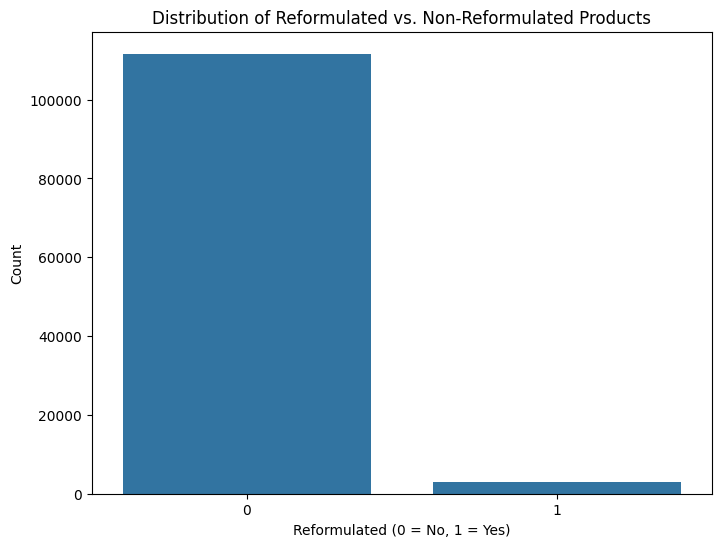

In [13]:
# Visualize the imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='Reformulated', data=df)
plt.title('Distribution of Reformulated vs. Non-Reformulated Products')
plt.xlabel('Reformulated (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

#**2.**

Cleaning inconsistent data...

In [14]:
# Standardize company names by removing 'INC.' and trimming whitespace
df['CompanyName'] = df['CompanyName'].str.replace('INC.', '', regex=False).str.strip()

# Standardize product names by converting to uppercase and trimming whitespace
df['ProductName'] = df['ProductName'].str.strip().str.upper()

# Dropped the 'CSF' column because it contains a high number of missing values...
df.drop('CSF', axis=1, inplace=True)

In [15]:

df['InitialDateReported'] = pd.to_datetime(df['InitialDateReported'], errors='coerce')
df['MostRecentDateReported'] = pd.to_datetime(df['MostRecentDateReported'], errors='coerce')

print("\nDataset after cleaning and feature engineering:")
print(df.info())
print("\n")
print(df.head())


Dataset after cleaning and feature engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114635 entries, 0 to 114634
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   CDPHId                  114635 non-null  int64         
 1   ProductName             114635 non-null  object        
 2   CSFId                   80662 non-null   float64       
 3   CompanyId               114635 non-null  int64         
 4   CompanyName             114635 non-null  object        
 5   BrandName               114408 non-null  object        
 6   PrimaryCategoryId       114635 non-null  int64         
 7   PrimaryCategory         114635 non-null  object        
 8   SubCategoryId           114635 non-null  int64         
 9   SubCategory             114635 non-null  object        
 10  CasId                   114635 non-null  int64         
 11  CasNumber               108159 non-null  o

#**3**


In [17]:
chemical_hazard_map = {
    'Formaldehyde': 'Confirmed Carcinogen',
    'Titanium dioxide': 'Suspected Carcinogen',
    'Distillates (coal tar)': 'Confirmed Carcinogen',
    'Fragrance': 'Allergen/Irritant',
    'Linalool': 'Allergen/Irritant',
    'Glycerin': 'Not Hazardous',
    'Ethanol': 'Not Hazardous',
    'Sodium Lauryl Sulfate': 'Allergen/Irritant'
}

# Identify unique chemicals and map them to their hazard types
# We will create a new 'HazardType' column in the DataFrame.
df['ChemicalName_Clean'] = df['ChemicalName_Clean'].str.strip()  # Ensure no leading/trailing whitespace
df['HazardType'] = df['ChemicalName_Clean'].map(chemical_hazard_map).fillna('Not Classified')

# Summarize the distribution of chemical hazard types
hazard_distribution = df['HazardType'].value_counts()
print("Distribution of Chemical Hazard Types:")
print(hazard_distribution)
print("\n")

Distribution of Chemical Hazard Types:
HazardType
Suspected Carcinogen    93480
Not Classified          21152
Confirmed Carcinogen        3
Name: count, dtype: int64




This maps chemicals to their hazard categories to prepare the data for risk analysis. It begins with a pre-defined dictionary (chemical_hazard_map) that was created using an external tool (like ChatGPT) for efficiency and then validated manually.

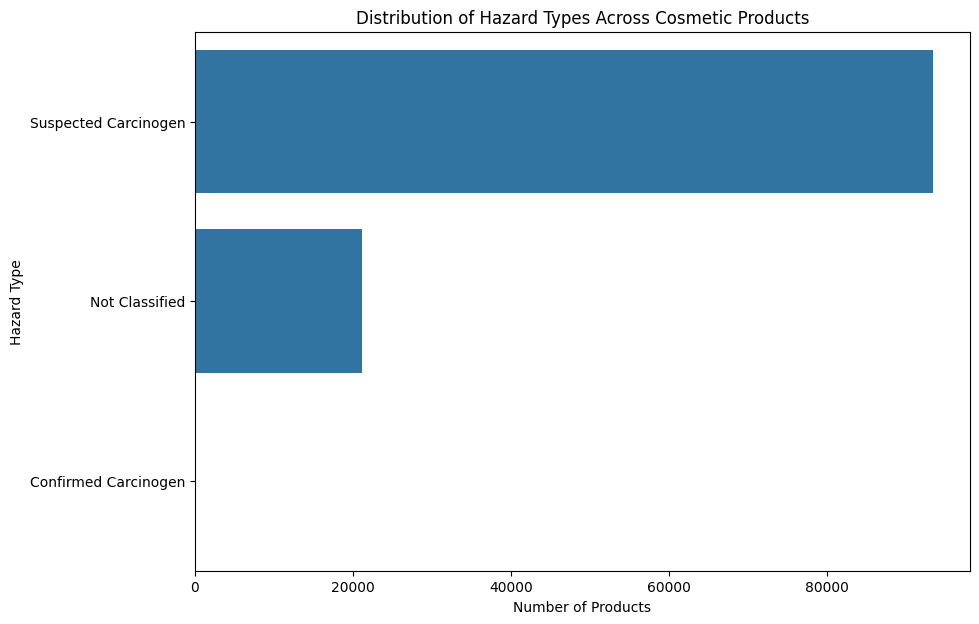

In [18]:
# Visualize the hazard distribution
plt.figure(figsize=(10, 7))
sns.countplot(y='HazardType', data=df, order=df['HazardType'].value_counts().index)
plt.title('Distribution of Hazard Types Across Cosmetic Products')
plt.xlabel('Number of Products')
plt.ylabel('Hazard Type')
plt.show()

Made a new HazardType column, classifying each chemical. Finally, it generates a summary table and a bar chart to visualize the distribution of these hazard types, providing a quick, clear overview of the potential risks within the dataset.